# pypwsqc

[insert package explanation]

The original R code stems from https://github.com/LottedeVos/PWSQC

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import packages

import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr

import pypwsqc as pws

## Load example data
[short description of example data]

In [3]:
!curl -OL https://github.com/OpenSenseAction/OS_data_format_conventions/raw/main/notebooks/data/OpenSense_PWS_example_format_data.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 5687k    0 38320    0     0  23224      0  0:04:10  0:00:01  0:04:09 23224
 57 5687k   57 3264k    0     0  1532k      0  0:00:03  0:00:02  0:00:01 6708k
100 5687k  100 5687k    0     0  2523k      0  0:00:02  0:00:02 --:--:-- 9339k


In [4]:
# read PWS data with xarray
ds_pws = xr.open_dataset("OpenSense_PWS_example_format_data.nc")

# rename to follow opensense naming convention
ds_pws = ds_pws.rename_vars({"longitude": "lon", "latitude": "lat"})

# slice to time of interest
# ds_pws = ds_pws.sel(time=slice("2017-09-13 00:00:00", "2017-09-13 03:00"))

ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 ...
    lon        (id) float64 ...
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [5]:
# %matplotlib widget

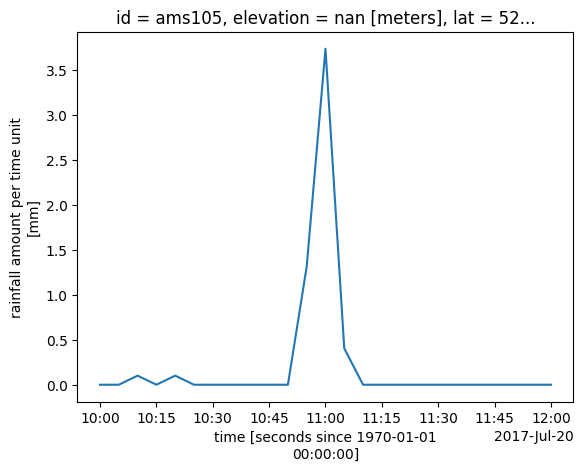

In [6]:
ds_pws.rainfall.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
).plot()

In [7]:
rain_array = ds_pws.rainfall.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
)
rain_array.data

array([0.   , 0.   , 0.101, 0.   , 0.101, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 1.313, 3.737, 0.404, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [8]:
rain = np.array(
    [
        0.0,
        0.0,
        0.101,
        0.0,
        0.101,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        1.3130001,
        3.7370002,
        0.404,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ]
)
rain

array([0.       , 0.       , 0.101    , 0.       , 0.101    , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 1.3130001,
       3.7370002, 0.404    , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       ])

## Create distance matrix

[Preparations below both apply to HI and FZ filter. Apply poligrain here]


### Reproject coordinates to metric projection to allow for distance calculations 

In [9]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.lon, y=ds_pws.lat, target_projection="EPSG:25832"
)

### Calculate distance between all stations of the network in meters

In [10]:
# create a sparse matrix --> to be applicable for large datasets

distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

### Calculate number of neighbours reporting rainfall per timestep

In [11]:
# select range maximum_distance in which to find neighbours
max_distance = 10e3  # range around each station, meters

In [12]:
%%time
ds_pws = ds_pws.load()

nbrs_not_nan = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        distance_matrix.sel(id=pws_id) < max_distance
    ]
    N = ds_pws.rainfall.sel(id=neighbor_ids).isnull().sum(dim="id")
    nbrs_not_nan.append(N)

ds_pws["nbrs_not_nan"] = xr.concat(nbrs_not_nan, dim="id")

CPU times: total: 31.2 s
Wall time: 31.6 s


Text(0.5, 1.0, 'nbrs not nan ams105')

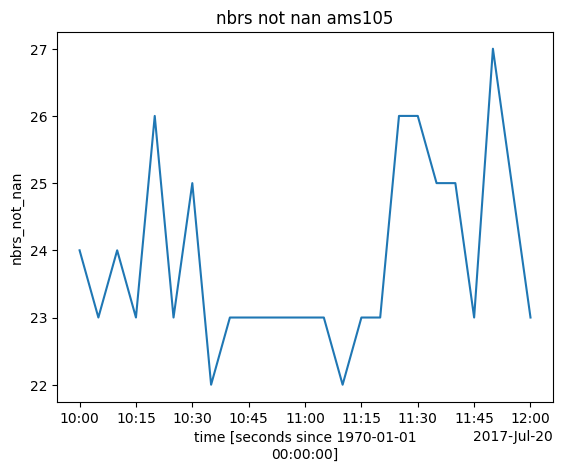

In [13]:
ds_pws.nbrs_not_nan.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
).plot()
plt.title("nbrs not nan ams105")

In [14]:
nbrs_array = ds_pws.nbrs_not_nan.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
)
nbrs_array.data

array([24, 23, 24, 23, 26, 23, 25, 22, 23, 23, 23, 23, 23, 23, 22, 23, 23,
       26, 26, 25, 25, 23, 27, 25, 23])

In [15]:
nbrs = np.array(
    [
        24,
        23,
        24,
        23,
        26,
        23,
        25,
        22,
        23,
        23,
        23,
        23,
        23,
        23,
        22,
        23,
        23,
        26,
        26,
        25,
        25,
        23,
        27,
        25,
        23,
    ]
)

In [16]:
nbrs_float = nbrs.astype(float)
nbrs_float

array([24., 23., 24., 23., 26., 23., 25., 22., 23., 23., 23., 23., 23.,
       23., 22., 23., 23., 26., 26., 25., 25., 23., 27., 25., 23.])

In [17]:
# expected result for max_distance = 10e3, hi_thres_a = 0.4, hi_thres_b = 3
expected = np.array(
    [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        1,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ]
)
expected

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

## Calculate reference

The default reference of the filter is to compare the observed rainfall of a given station with the median rainfall from all stations within a range `d`. If the median is below the threshold value `HIthresA`, the HI flag for the station is set to 1 (i.e. high influx) for rainfall amounts above threshold `HIthresB`. When the surrounding stations report moderate to heavy rainfall, the threshold becomes variable: for a median of `HIthresA` or higher, the station's HI flag is set to 1 when its measurements exceed the median times `HIthresB/HIthresA`. 

_Allow for other metrics in addition to median? Stochastic methods? Propose other metrics for variable_ `reference`? Compare with secondary data?

In [18]:
%%time

reference = []

for pws_id in ds_pws.id.data:
    neighbor_ids = distance_matrix.id.data[
        distance_matrix.sel(id=pws_id) < max_distance
    ]
    median = ds_pws.sel(id=neighbor_ids).rainfall.median(dim="id")
    reference.append(median)

CPU times: total: 4min 38s
Wall time: 4min 40s


In [19]:
ds_pws["reference"] = xr.concat(reference, dim="id")
ds_pws

<xarray.Dataset>
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat           (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon           (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 8 8 8 8 8 8 8 8 8 8 ... 10 9 10 10 9 10 9 9 9
    reference     (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

Text(0.5, 1.0, 'median of neighbors ams105')

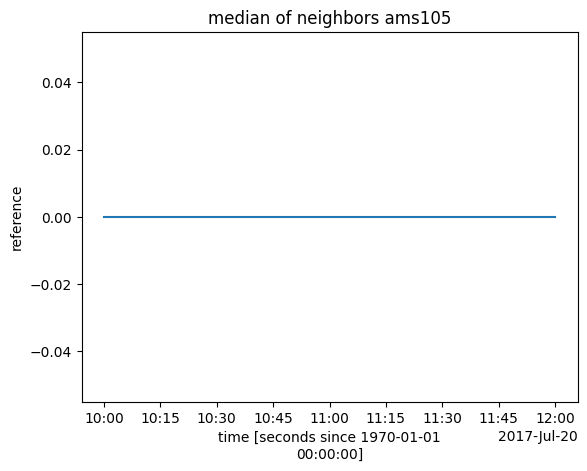

In [20]:
ds_pws.reference.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
).plot()
plt.title("median of neighbors ams105")

In [21]:
reference_array = ds_pws.reference.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
)
reference_array.data

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
reference_test = np.array(
    [
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
        0.0,
    ]
)
reference_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

## Faulty Zeroes filter

Conditions for raising Faulty Zeroes flag:

* FZflag is not -1
* Median rainfall of neighbouring stations within range `max_distance` is larger than zero for at least `nint` time intervals while the station itself reports zero rainfall.

The FZ flag remains 1 until the station reports nonzero rainfall. For settings for parameter `nint`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731 

In [23]:
# fz_flag = pws.flagging.fz_filter(
#    pws_data=ds_pws.rainfall,
#    reference=ds_pws.reference,
#    nint=3
# )

In [24]:
# ds_pws["fz_flag"]= fz_flag

## High Influx filter

Conditions for raising High Influx flag:
* If median below threshold `ϕA`, then high influx if rainfall above threshold `ϕB`
* If median above `ϕA`, then high influx if rainfall exceeds median times `ϕB`/`ϕA`

Filter cannot be applied if less than `nstat` neighbours are reporting data (HI flag is set to -1)

For settings for parameter `ϕA`, `ϕB` and `nstat`, see table 1 in https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL083731

In [28]:
hi_flag = pws.flagging.hi_filter(
    pws_data=ds_pws.rainfall,
    nbrs_not_nan=ds_pws.nbrs_not_nan,
    reference=ds_pws.reference,
    hi_thres_a=0.4,
    hi_thres_b=0.2,
    n_stat=5,
)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... -1 -1 -1]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [29]:
ds_pws["hi_flag"] = hi_flag
ds_pws

<xarray.Dataset>
Dimensions:       (time: 219168, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat           (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon           (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 nan 0.0 0.0 0.0
    nbrs_not_nan  (id, time) int32 8 8 8 8 8 8 8 8 8 8 ... 10 9 10 10 9 10 9 9 9
    reference     (id, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    hi_flag       (id, time) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

Text(0.5, 1.0, 'hi flag')

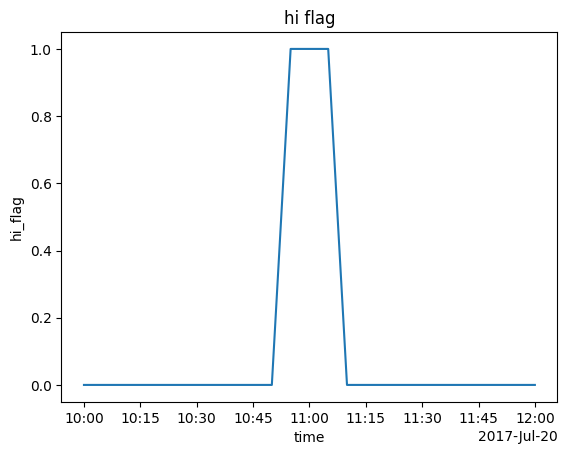

In [30]:
ds_pws.hi_flag.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
).plot()
plt.title("hi flag")

In [31]:
ds_pws.hi_flag.sel(
    id="ams105", time=slice("2017-07-20 10:00:00", "2017-07-20 12:00:00")
).data

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])